In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d

from kan import *
import use_KAN
from use_training_set import *


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu

cuda


# load training set

In [3]:
def RBF(d,lmbda):
    return np.exp(-d**2/2/lmbda**2)

def mldivide(A,B):
    return np.linalg.pinv(A).dot(B)
    
def sm_GP(qq,f,lmbda,sigma):
    d_ij = qq.reshape(len(qq),1) - qq.reshape(1,len(qq))
    
    K = RBF(d_ij,lmbda)
    K_s = K
    K_y = K + np.eye(len(qq))*sigma**2
    
    y = f
    L = np.linalg.cholesky(K_y)

    alpha = mldivide(L.T,mldivide(L,y))
    E = K_s.T@alpha
    
    return E

In [4]:
config_file = 'setup_ts.txt'
x_train, y_train, Q_train = load_training_data(config_file)
print(x_train.shape)
print(y_train.shape)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)
I_train = np.exp(y_train)

k_z = x_train[:, 0]
alpha = x_train[:, 2]
kappa = x_train[:, 1]
set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique((kappa)))

# Add a column of ones to x to account for the bias term
x_train_bias = np.hstack([x_train, np.ones((x_train.shape[0], 1))])

# Initialize A and B
A = np.zeros((x_train.shape[1], y_train.shape[1]))
B = np.zeros(y_train.shape[1])

# For each target variable
for i in range(y_train.shape[1]):
    # Solve for A and B using least squares
    coef, _, _, _ = np.linalg.lstsq(x_train_bias, y_train[:, i], rcond=None)
    A[:, i] = coef[:-1]
    B[i] = coef[-1]


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]
(2000, 3)
(2000, 126)


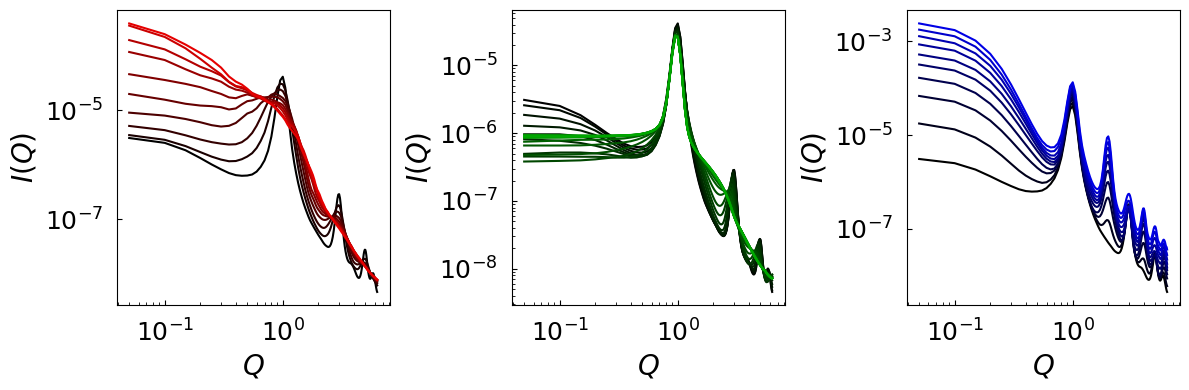

In [5]:
S_q_sm_Grid = np.exp(y_train)
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(k_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[1])<tol
    id_kappa = np.abs(kappa-parameters[2])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

# color
def color_params(parameters):
    k_z_reduced = np.clip((parameters[0] - 1) / 10, 0, 1)
    alpha_reduced = np.clip(parameters[1] / 1, 0, 1)
    kappa_reduced = np.clip((np.log(128)-parameters[2])/ 10, 0, 1)
    return [k_z_reduced, kappa_reduced, alpha_reduced]

def plot_data_all():
    ## plot results: varying k_z
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1,3,1)

    for i, k_z_i in enumerate(set_k_z):
        parameters = [k_z_i,set_alpha[0],set_kappa[0]]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(Q_train,S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$I(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ax = fig.add_subplot(1,3,2)

    for i, kappa_i in enumerate(set_kappa):
        parameters = [set_k_z[0],set_alpha[0],kappa_i]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(Q_train,S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$I(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ax = fig.add_subplot(1,3,3)

    for i, alpha_i in enumerate(set_alpha):
        parameters = [set_k_z[0],alpha_i,set_kappa[0]]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(Q_train,S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$I(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    plt.tight_layout()
    plt.show()

plot_data_all()

## Define model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu
torch.set_default_dtype(torch.float32)

cuda


In [7]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)

In [8]:
## define KAN model
Qx = np.vstack([Q_train,np.ones_like(Q_train)]).T
Qx_inv = to_torch_device((np.linalg.pinv(Qx)), device=device)
Qx = to_torch_device(Qx, device=device)

class SQ_KAN(nn.Module):
    def __init__(self, width=[4,11,1], width_aug=[3,7,7,3], grid=9, k=3, seed=42, device=device, multiplier=2):
        super(SQ_KAN, self).__init__()
        self.kan_aug = KAN(width=width_aug, grid=10, k=k, seed=seed, device=device, grid_eps = 1, noise_scale=0.1, base_fun = 'identity')
        self.kan_aug.update_grid_from_samples(x_train_torch)
        self.kan = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=0.1, base_fun = 'identity')
        self.Q_torch = to_torch_device((Q_train-2)/4)
        self.A = to_torch_device(A)
        self.B = to_torch_device(B)
        self.multiplier = multiplier
        
    def forward(self, x):
        bg = (x@self.A+self.B)
        # bg_expanded = bg.unsqueeze(1).expand(-1, self.Q_torch.size(0), -1)
        # Compute the mean of individual bg
        # bg_mean = bg_expanded.mean(dim=-1)
        # Linear approximation of the background
        Qab = Qx_inv@bg.T
        bg_lin = (Qx@Qab).T
        
        x = self.kan_aug(x)
        x_expanded = x.unsqueeze(1).expand(-1, self.Q_torch.size(0), -1)
        Q_expanded = self.Q_torch.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
        Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
        Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
        sq_full = self.kan(Q_params_reshaped)
        sq_full_reshaped = sq_full.view(x.size(0), self.Q_torch.size(0))
        return sq_full_reshaped*self.multiplier + bg_lin
    
model_KAN = SQ_KAN(width=[4,9,1], width_aug=[3,7,3], grid=20, k=3, seed=11451419, device=device)

# x_train_torch = to_torch_device(x_train)
# x = x_train_torch[0:2]
# model_KAN.forward(x)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


## Train KAN

In [9]:
def visualize_training_KAN(model, epoch, loss_list, x_ind, y_ind, save_path, savefig=True):
    os.makedirs(save_path, exist_ok=True)
    
    # bg = (x_ind@to_torch_device(A)+to_torch_device(B)).detach().cpu().numpy()
    y_pred_ind = model(x_ind)
    clear_output(wait=True)
    plt.figure(figsize=(11.5, 8))  # adjust the size as needed
    gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 2])

    for i in range(9):
        ax = plt.subplot(gs[i//3, i%3])
        length_y = y_ind.shape[1]
        q = Q_train
        y_train_plot = np.exp(y_ind[i].detach().cpu().numpy())#-bg[i])
        y_pred_plot = np.exp(y_pred_ind[i].detach().cpu().numpy())#-bg[i])
        ax.plot(q,y_train_plot, label='True')
        ax.plot(q,y_pred_plot, label='Predicted')
        ax.set_xticks([0,1,2,3,4,5,6])
        ax.set_xticklabels(["","1","2","3","","",""])
        ax.set_xlim([-0.5,6.5])
        # ax.set_ylim([5e-9,5e-3])
        ax.set_ylim([1e-9,1e-3])
        ax.set_yscale("log")
        ax.set_xlabel(r'$QD$')
        ax.set_ylabel(r'$S(QD)$')        
        ax.set_aspect(7/6)  # Set aspect ratio to 1

    # Add a subplot for the training loss
    ax_loss = plt.subplot(gs[:, 3])
    ax_loss.plot(loss_list, label='Training loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_yscale('log')
    ax_loss.legend()
    
    # Get the current x and y limits
    x_range = ax_loss.get_xlim()
    y_range = ax_loss.get_ylim()

    # Calculate the ranges
    x_span = x_range[1] - x_range[0]
    y_span = np.log10(y_range[1]) - np.log10(y_range[0])

    # Set the aspect ratio
    if x_span > y_span:
        ratio = x_span / y_span
        ax_loss.set_aspect(ratio)
    else:
        ratio = y_span / x_span
        ax_loss.set_aspect(1.0 / ratio)

    plt.suptitle(f'Epoch {epoch}, Loss: {loss_list[-1]}')
    plt.tight_layout()
    
    # Save the figure to a file
    if epoch % 200 == 0:
        if savefig:
            plt.savefig(os.path.join(save_path, f'epoch_{epoch:04d}.png'))
        
    plt.show()
    plt.pause(0.001)

def train_model_KAN(model, x_train, y_train, epochs=100, batch_size=256, lr=1e-3, l2_reg=0.001, savefig=True):
    # Convert numpy arrays to PyTorch tensors
    x_train_torch = to_torch_device(x_train)
    y_train_torch = to_torch_device(y_train)

    # Create a DataLoader
    dataset = TensorDataset(x_train_torch, y_train_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define a loss function
    criterion = nn.MSELoss()
    # criterion = nn.HuberLoss()

    # Define an optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Randomly pick 9 indices for plotting
    np.random.seed(114514)
    indices = np.random.choice(len(y_train), size=12, replace=False)

    lost_list = []
    for epoch in range(epochs):
        for x_batch, y_batch in dataloader:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(x_batch)

            # Compute and print loss
            index_loss = np.random.randint(126, size=96)
            loss = criterion(y_pred[:,index_loss], y_batch[:,index_loss])
            
            # # Add L2 regularization
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = loss + l2_reg * l2_norm

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lost_list.append(loss.item())

        # Plot the selected curves
        save_path="./figures/KAN/"
        if epoch == 0:
            # Remove all files in the save_path directory
            for filename in os.listdir(save_path):
                file_path = os.path.join(save_path, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                except Exception as e:
                    print('Failed to delete %s. Reason: %s' % (file_path, e))
        if epoch % 1 == 0:
            # Print loss for this epoch
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            
            visualize_training_KAN(model, epoch, lost_list, x_train_torch[indices], y_train_torch[indices], save_path, savefig=savefig)
            # plt.figure(figsize=(6, 4))
            # plt.plot(lost_list)
            # plt.xlabel('Epoch')
            # plt.ylabel('Loss')
            # plt.yscale('log')
            # # plt.xscale('log')
            # plt.show()
            
        # if epoch % 10 == 0:
            model.kan_aug.plot(scale=1)
            model.kan.plot(scale=1)

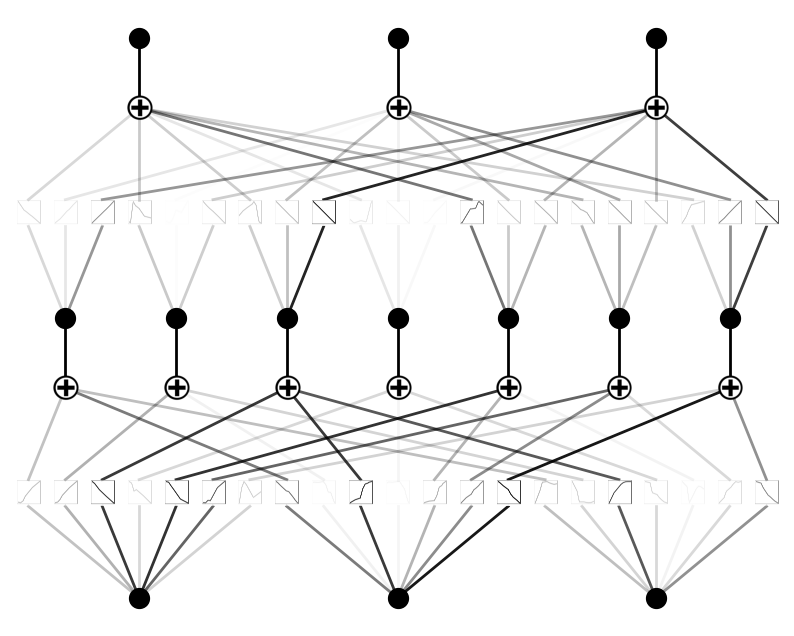

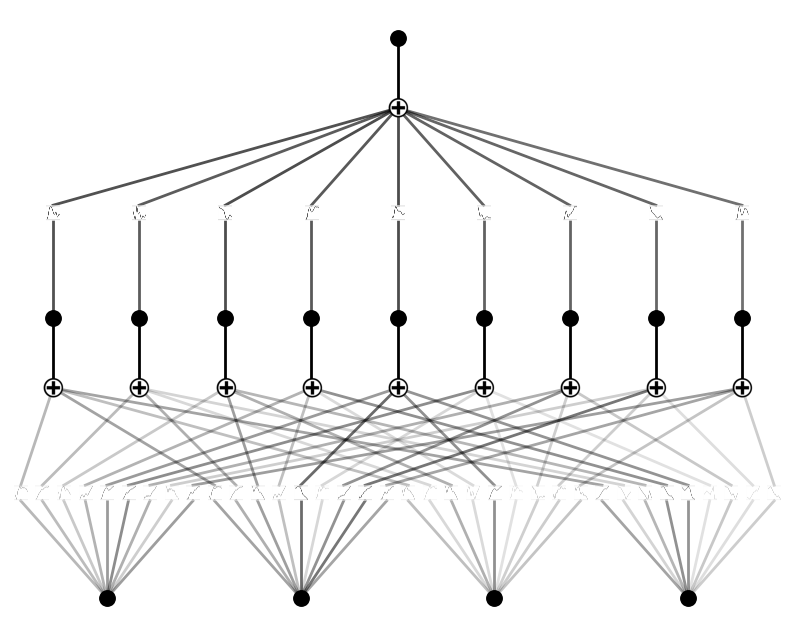

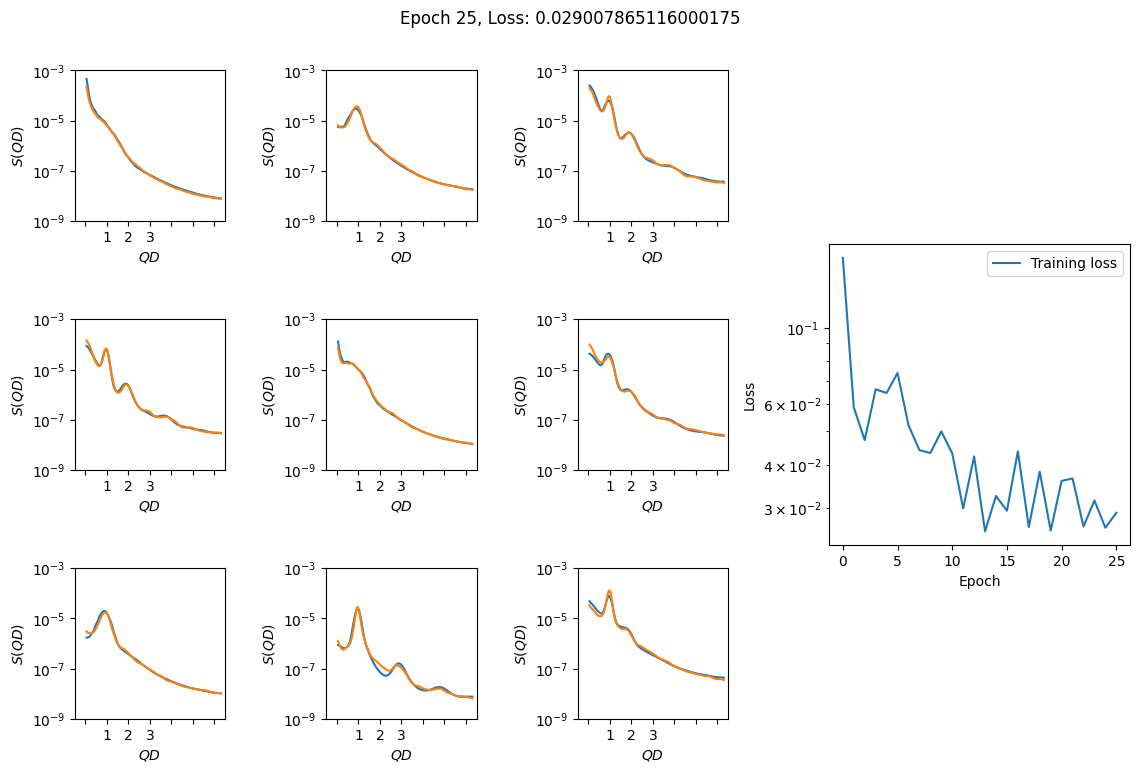

In [10]:
train_model_KAN(model_KAN, x_train, y_train, epochs=500, batch_size=100, l2_reg=0, lr=5e-3)

In [11]:
torch.save(model_KAN.state_dict(), './saved_model/KAN/model_7_9_grid_lin.pth')

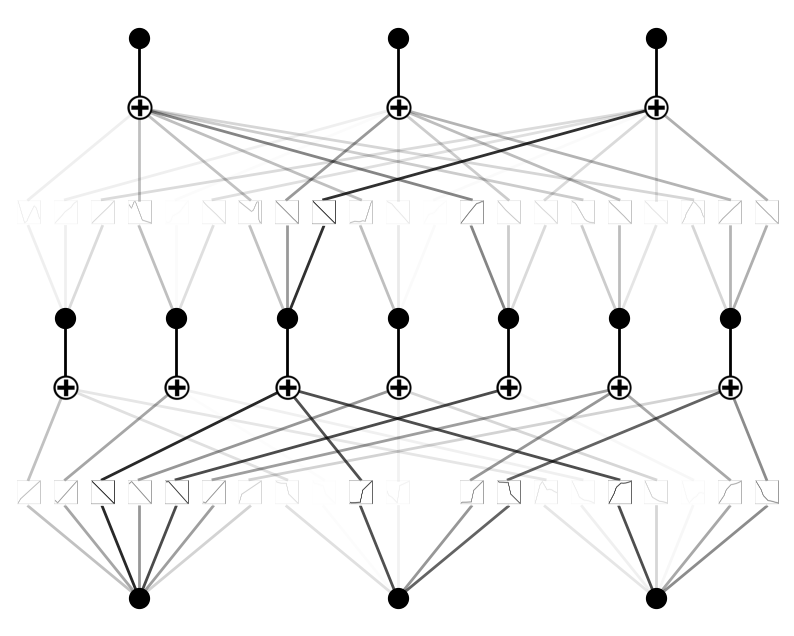

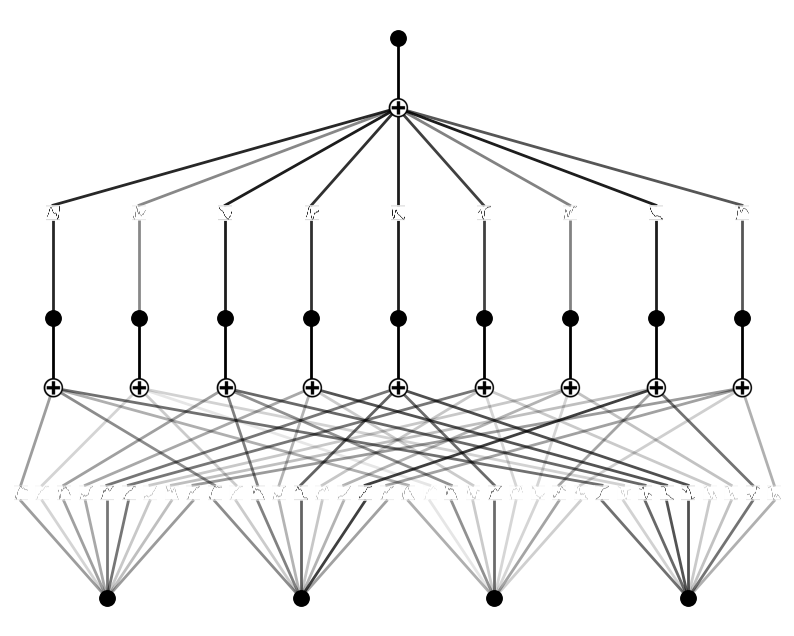

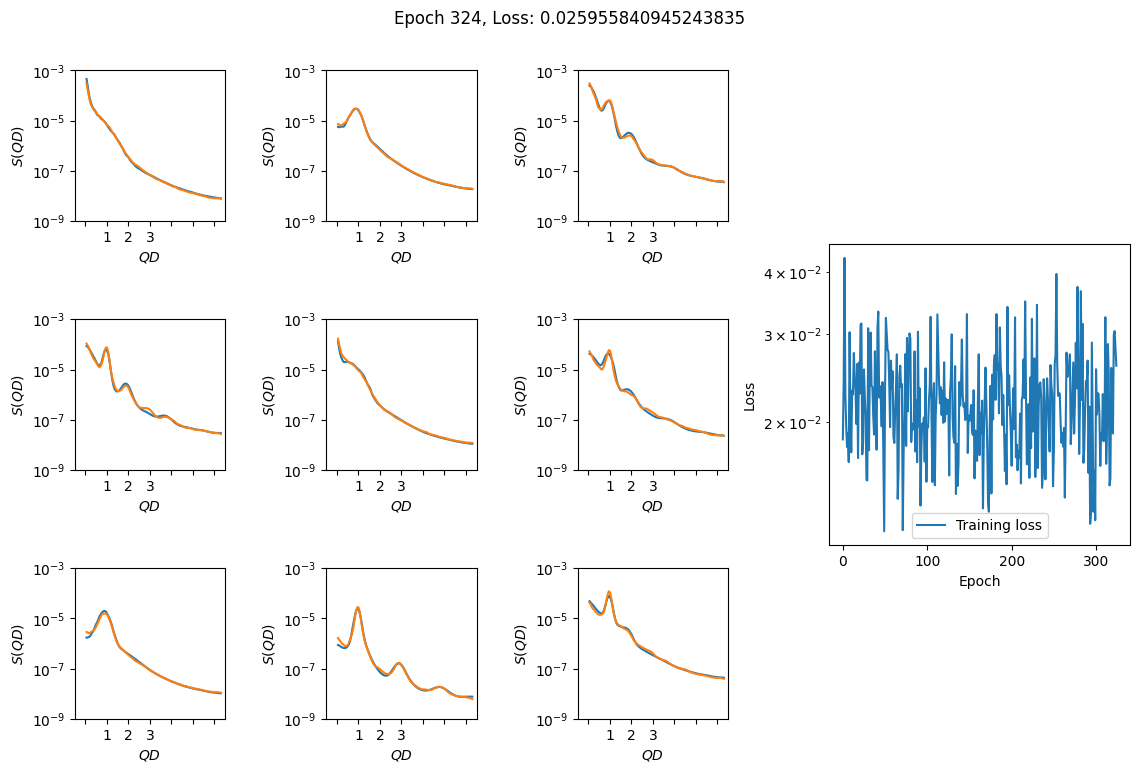

KeyboardInterrupt: 

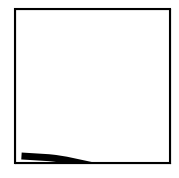

In [12]:
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_7_9_grid_lin.pth'))
train_model_KAN(model_KAN, x_train, y_train, epochs=2000, batch_size=50, l2_reg=0, lr=2e-3)

In [14]:
fneme = "./saved_model/KAN/model_7_9_grid_ft_lin.pth"
torch.save(model_KAN.state_dict(), fneme)

In [15]:
fname_BR = "./saved_model/KAN/model_7_9_grid_ft_lin.pth"
torch.save(model_KAN.state_dict(), './saved_model/KAN/model_BR.pth')

# Open the file in write mode
with open("./saved_model/KAN/model_BR.txt", 'w') as file:
    # Write the modified contents back to the file
    file.writelines(fname_BR)
    file.writelines("")
    

In [16]:
import yaml
def generate_model_setup_txt(fname_txt):
    config = {
        'Model Setup': {
            'model_class': 'SQ_KAN',
            'width': [4, 9, 1],
            'width_aug': [3, 7, 3],
            'grid': 20,
            'k': 3,
            'seed': 11451419,
            'device': 'cuda',
            'grid_eps': 1,
            'noise_scale': 1,
            'base_fun': 'identity',
            'multiplier': 2
        },
        'Training Configuration': {
            # Add any training-specific parameters here if needed
        }
    }

    with open(fname_txt, 'w') as file:
        yaml.dump(config, file)

generate_model_setup_txt('setup_model_7_9.txt')